In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
#Etape 2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from scikitplot.metrics import plot_cumulative_gain, plot_precision_recall
from sklearn import preprocessing
from sklearn import metrics
import proj_func


%matplotlib inline

In [98]:
raw_data = pd.read_csv('octroi_RCI.csv', sep = ';', decimal= ',', header=0, parse_dates=['mois_gestion'], dtype = {'STITUATION_FAM':'category', 'MODE_LOGT':'category', 'VN_VO':'category', 'MARQUE':'category', 'anciennete_rci':'category', 'def12_31': 'category'})
df = raw_data.copy()
df = df.drop('mois_gestion', axis=1)
#df = df.drop('def12_31', axis=1)
raw_data.head() #(8457, 19)

,ANC_EMPLOI,STITUATION_FAM,MODE_LOGT,AGE_VEH,VN_VO,MARQUE,PRIX_VEH,MT_APPORT,MT_FINANCE,MT_MENS,VR_BALLON,DUREE_CONTRAT,MT_PREST,MT_ASSUR,mois_gestion,age_cli,anciennete_rci,pc_appo,def12_31
0,65,2,1,NaN,VN,REN,19584.65,0.0,19584.65,95.01,19584.63,6,NaN,NaN,2015-01-03,28,1,0,0
1,563,11,2,28.0,VO,REN,16995.00,2123.0,14872.00,312.34,NaN,60,150.0,NaN,2014-01-06,64,3,12,0
2,107,2,2,16.0,VO,REN,19950.00,3869.0,16081.00,329.93,NaN,60,150.0,NaN,2015-01-08,51,3,19,0
3,143,2,2,10.0,VO,REN,17500.00,7143.5,10356.50,217.51,NaN,60,150.0,NaN,2015-01-04,42,4,41,0
4,110,2,NaN,7.0,VO,REN,19740.00,3789.4,15950.60,310.33,7523.04,36,150.0,395.0,2015-01-02,34,4,19,0


In [99]:
df2 = pd.read_csv('data_output.csv')
df2.drop(['Unnamed: 0'], axis=1, inplace=True)

In [100]:
#df3 = pd.read_csv('pour_francois.csv')
#df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [101]:
y = raw_data['def12_31']

In [102]:
print(df2.shape, y.shape)

(8457, 76) (8457,)


## Cross Validation

In [103]:
#Cross validation 
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size= 0.3, stratify=y, random_state=1) 
#print(len(X_train.loc[X_train['def12_31']=='0']), len(X_train.loc[X_train['def12_31']=='1']))
#print(len(X_test.loc[X_test['def12_31']=='0']), len(X_test.loc[X_test['def12_31']=='1']))
print(69/5850, 29/2509) #même distribution dans X_train et X_test ! 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

0.011794871794871795 0.011558389796731766
(5919, 76) (2538, 76) (5919,) (2538,)


## Rééchantillonnage : SMOTE

(11700, 76)


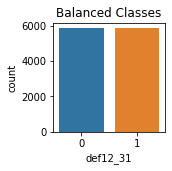

In [104]:
#SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, k_neighbors=5).fit_resample(X_train, y_train)
#Vérification
print(X_resampled.shape)
fig, ax = plt.subplots(figsize=(2,2))
sns.countplot('def12_31', data=pd.concat([X_resampled,y_resampled], axis=1))
ax.set_title('Balanced Classes');

In [105]:
#Scaling
X_sc_resampled = pd.DataFrame(preprocessing.scale(X_resampled), columns=X_resampled.columns)
X_sc_test = pd.DataFrame(preprocessing.scale(X_test), columns= X_test.columns)

In [106]:
y_resampled = y_resampled.astype('uint8')

In [107]:
y_train = y_train.astype('uint8')

In [108]:
params = {
    'penalty':('l2', 'none'), 
    #'C': (0.001, 0.01, 0.1),
    #'solver': ['newton-cg', 'lbfgs', 'sag'],    
    #'l1_ratio': np.arange(0.1,0.9,0.1),
}

clf = GridSearchCV(
    estimator = LogisticRegression(max_iter=10000),
    param_grid = params,
    cv = 5, #specify the number of folds in a (Stratified)KFold
    scoring =['precision', 'recall', 'f1'],
    refit = 'f1',
    n_jobs = -1, #1 pas de parallélisation / -1 parallélisation
    verbose=1
    )
    
#clf.fit(X_resampled, y_resampled)

In [109]:
#Tableau des résultats de gridsearch : 
#Note : j'ai appelé clf = gridsearchCV
#res = pd.DataFrame(clf.cv_results_)

#Je garde uniquement ces variables :
#feats = ['param_C', 'param_penalty', 'param_solver','mean_test_precision', \
#'mean_test_recall','mean_test_f1', 'rank_test_f1']

#feats = ['param_penalty','mean_test_precision', \
#'mean_test_recall','mean_test_f1', 'rank_test_f1']

#res[feats].sort_values('rank_test_f1')

/Users/francoislegac/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


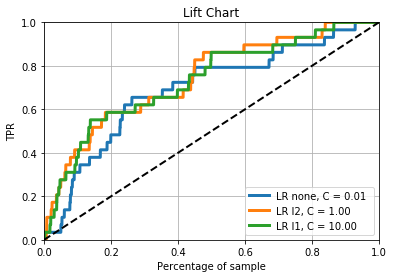

In [110]:

arg_models = [
    LogisticRegression(solver='newton-cg', C=0.01, penalty='none', max_iter=10000),
    LogisticRegression(solver='newton-cg', C=1, penalty='l2', max_iter=10000),
    LogisticRegression(solver='liblinear', C=10, penalty='l1', max_iter=10000),
]

fig = proj_func.plot_several_lifts(arg_models, X_sc_resampled, X_sc_test, y_resampled, y_test)

In [114]:
clf = LogisticRegression(solver='liblinear', penalty='l1', C=10)
y_test = y_test.astype('uint8')
df = proj_func.lift_table(clf, X_sc_resampled, X_sc_test, y_resampled, y_test)
df

,alpha,effectif,nb_positif,pc_positif,alpha_lift,cum_effectif,cum_positif,cum_alpha_lift
0,0.1,254,12,4.724409,4.134673,254,12,4.134673
1,0.2,254,5,1.968504,1.722780,508,17,2.928727
2,0.3,254,1,0.393701,0.344556,762,18,2.067336
3,0.4,254,2,0.787402,0.689112,1016,20,1.722780
4,0.5,254,5,1.968504,1.722780,1270,25,1.722780
5,0.6,254,0,0.000000,0.000000,1524,25,1.435650
6,0.7,254,1,0.393701,0.344556,1778,26,1.279780
7,0.8,254,1,0.393701,0.344556,2032,27,1.162877
8,0.9,254,2,0.787402,0.689112,2286,29,1.110236
9,1.0,254,0,0.000000,0.000000,2540,29,0.999213


In [116]:
df.to_csv('lift_table.csv')